# Classification Animals-10 using CNN
Task: load the Animals-10, write a simple CNN to perform classification over most frequent face classes, test the network and plot the results for each class.

<!-- ![Animals-10](https://storage.googleapis.com/kaggle-datasets-images/59760/115796/95649e825d9344084af2a24012c4d072/dataset-cover.jpg?t=2018-10-05-08-07-40) -->

### Importing libraries

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms 
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn.metrics import classification_report
from torchmetrics.functional.classification.accuracy import accuracy
%matplotlib inline
%config InlineBackend.figure_format = "svg"

### Importing dataset

In [ ]:
# Defining the transformations on the images
transform=transforms.Compose([
  transforms.RandomRotation(10),      # rotate +/- 10 degrees
  transforms.RandomHorizontalFlip(),  # reverse 50% of images
  transforms.Resize(144),             # resize shortest side to 224 pixels
  transforms.CenterCrop(144),         # crop longest side to 224 pixels at center
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Load the dataset
dataset=datasets.ImageFolder(root="animals10/raw-img",transform=None)

class_names=dataset.classes
print(class_names)
print(len(class_names))

# Print number of images in each class
num_images = {class_names[i]: len(os.listdir(f"animals10/raw-img/{class_names[i]}")) for i in range(len(class_names))}
print(num_images)

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
10
{'cane': 4863, 'cavallo': 2623, 'elefante': 1446, 'farfalla': 2112, 'gallina': 3098, 'gatto': 1668, 'mucca': 1866, 'pecora': 1820, 'ragno': 4821, 'scoiattolo': 1862}


### Defining the data loader

In [4]:
class DataModule(pl.LightningDataModule):
  def __init__(self, transform=transform, batch_size=32):
    super().__init__()
    self.root_dir = "animals10/raw-img"
    self.transform = transform
    self.batch_size = batch_size

  def setup(self, stage=None):
    dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.7, 0.2, 0.1], generator=torch.Generator().manual_seed(42))

    if stage == 'fit' or stage is None:
      self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
      self.val_dataset = DataLoader(val_dataset, batch_size=self.batch_size)
    elif stage == 'test' or stage is None:
      self.test_dataset = DataLoader(test_dataset, batch_size=self.batch_size)
      
  def train_dataloader(self):
    return self.train_dataset
  
  def val_dataloader(self):
    return self.val_dataset
  
  def test_dataloader(self):
    return self.test_dataset

### Defining the CNN model

In [ ]:
class ConvolutionalNetwork(LightningModule):
  def __init__(self):
    super(ConvolutionalNetwork, self).__init__()

    self.ground_truth = []
    self.predictions = []

    self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
    self.conv3 = nn.Conv2d(32, 48, 3, padding =1)
    self.conv4 = nn.Conv2d(48, 64, 3, padding =1)
    self.conv5 = nn.Conv2d(64, 80, 3, padding =1)
    
    self.pool = nn.MaxPool2d(2,2)
    
    self.fc1 = nn.Linear(4*4*80, 980)
    self.fc2 = nn.Linear(980, 123)
    self.fc3 = nn.Linear(123, 10)
    
    self.dropout = nn.Dropout(p= 0.25)
    self.batchn1 = nn.BatchNorm2d(16)
    self.batchn2 = nn.BatchNorm2d(32)
    self.batchn3 = nn.BatchNorm2d(48)
    self.batchn4 = nn.BatchNorm2d(64)
    self.batchn5 = nn.BatchNorm2d(80)

  def forward(self, x):
    x = self.pool(F.relu(self.batchn1(self.conv1(x))))
    x = self.pool(F.relu(self.batchn2(self.conv2(x))))
    x = self.pool(F.relu(self.batchn3(self.conv3(x))))
    x = self.pool(F.relu(self.batchn4(self.conv4(x))))
    x = self.pool(F.relu(self.batchn5(self.conv5(x))))
    x = torch.flatten(x, 1)
    
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = F.log_softmax(self.fc3(x), dim=1)
    return x

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
    return optimizer

  def training_step(self, batch, batch_idx):
    input, target = batch
    input = self(input)
    loss = F.cross_entropy(input, target)

    preds = torch.argmax(input, dim=1)
    acc = accuracy(preds, target, task='multiclass',num_classes=len(target))

    self.log("train_loss", loss, prog_bar=True, on_epoch=True, on_step=False, logger=True)
    self.log("train_acc", acc, prog_bar=True, on_epoch=True, on_step=False, logger=True)

    return loss

  def validation_step(self, batch, batch_idx):
    input, target = batch
    input = self(input)
    loss = F.cross_entropy(input, target)

    preds = torch.argmax(input, dim=1)
    acc = accuracy(preds, target, task='multiclass', num_classes=len(target))

    self.log("val_loss", loss, prog_bar=True, on_epoch=True, on_step=False, logger=True)
    self.log("val_acc", acc, prog_bar=True, on_epoch=True, on_step=False, logger=True)

    return loss

  def test_step(self, batch, batch_idx):
    input, target = batch
    input = self(input)
    loss = F.cross_entropy(input, target)

    preds = torch.argmax(input, dim=1)
    acc = accuracy(preds, target, task='multiclass', num_classes=len(target))

    self.ground_truth.append(target.data)     # Save ground truth
    self.predictions.append(preds.data)       # Save predictions

    self.log("test_loss", loss, prog_bar=True, on_epoch=True, on_step=False, logger=True)
    self.log("test_acc", acc, prog_bar=True, on_epoch=True, on_step=False, logger=True)

    return loss

### Training the model

In [6]:
datamodule = DataModule()
datamodule.setup()
model = ConvolutionalNetwork()
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, datamodule)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/salvatore/Library/Python/3.13/lib/python/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

   | Name    | Type        | Params | Mode 
-------------------------------------------------
0  | conv1   | Conv2d      | 448    | train
1  | conv2   | Conv2d      | 4.6 K  | train
2  | conv3   | Conv2d      | 13.9 K | train
3  | conv4   | Conv2d      | 27.7 K | train
4  | conv5   | Conv2d      | 46.2 K | train
5  | pool    | MaxPool2d

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/salvatore/Library/Python/3.13/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/Users/salvatore/Library/Python/3.13/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 573/573 [01:37<00:00,  5.86it/s, v_num=196, val_loss=0.705, val_acc=0.796, train_loss=0.367, train_acc=0.878]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 573/573 [01:37<00:00,  5.86it/s, v_num=196, val_loss=0.705, val_acc=0.796, train_loss=0.367, train_acc=0.878]


### Plotting accuracy evolution over epochs

Latest version: 196


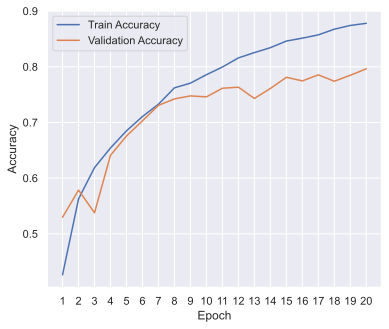

In [7]:
import pandas as pd

# Load the logs
# Load the latest version of the logs
log_dir = 'lightning_logs'
latest_version = max([int(d.split('_')[-1]) for d in os.listdir(log_dir) if d.startswith('version_')])
metrics = pd.read_csv(f'{log_dir}/version_{latest_version}/metrics.csv')

print(f'Latest version: {latest_version}')

# Extract the relevant data
train_acc = metrics['train_acc'].dropna().values
val_acc = metrics['val_acc'].dropna().values
# Ensure both arrays have the same length
min_length = min(len(train_acc), len(val_acc))
train_acc = train_acc[:min_length]
val_acc = val_acc[:min_length]
epochs = range(1, min_length + 1)
# Plot train and validation accuracy
plt.figure(figsize=(6, 5))
plt.xticks(epochs, [str(epoch) for epoch in epochs])
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Testing model on test set

In [8]:
datamodule.setup(stage='test')
test_loader = datamodule.test_dataloader()
trainer.test(dataloaders=test_loader)

/Users/salvatore/Library/Python/3.13/lib/python/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /Users/salvatore/Desktop/Uni/Vision and recognition/lightning_logs/version_196/checkpoints/epoch=19-step=11460.ckpt
Loaded model weights from the checkpoint at /Users/salvatore/Desktop/Uni/Vision and recognition/lightning_logs/version_196/checkpoints/epoch=19-step=11460.ckpt
/Users/salvatore/Library/Python/3.13/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` 

Testing DataLoader 0: 100%|██████████| 82/82 [00:09<00:00,  8.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7967137694358826
        test_loss           0.6746170520782471
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6746170520782471, 'test_acc': 0.7967137694358826}]

Text(74.45000000000006, 0.5, 'predicted label')

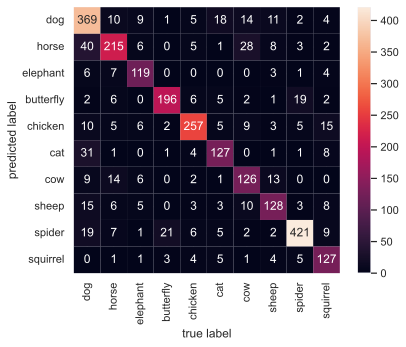

In [10]:
from sklearn.metrics import confusion_matrix

# Assuming class_labels contains the animal names
animal_names = ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']

# Flatten the ground truth and predictions
ground_truth_flat = torch.cat(model.ground_truth).cpu().numpy()
predictions_flat = torch.cat(model.predictions).cpu().numpy()

# Compute the confusion matrix
cm = confusion_matrix(predictions_flat, ground_truth_flat)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', xticklabels=animal_names, yticklabels=animal_names, square=True)
plt.xlabel('true label')
plt.ylabel('predicted label')

### Validate model on validation set

In [11]:
# Validate the model
trainer.validate(model, datamodule=datamodule)

/Users/salvatore/Library/Python/3.13/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Validation DataLoader 0: 100%|██████████| 164/164 [00:15<00:00, 10.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.7908709049224854
        val_loss            0.7206727862358093
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.7206727862358093, 'val_acc': 0.7908709049224854}]

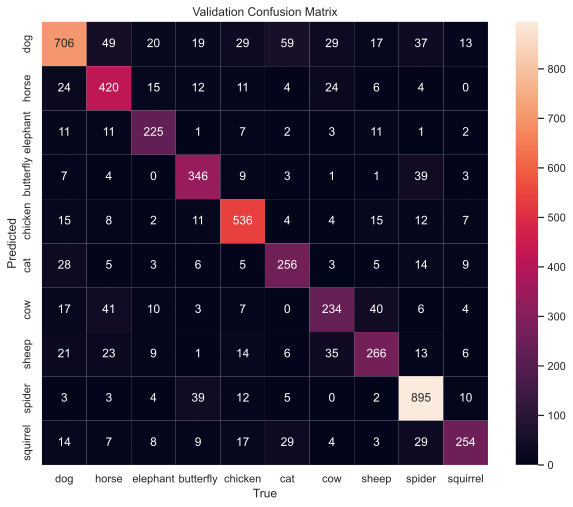

In [12]:
# Get validation data
val_loader = datamodule.val_dataloader()
ground_truth_val = []
predictions_val = []

# Collect predictions and ground truth
model.eval()
with torch.no_grad():
  for batch in val_loader:
    images, labels = batch
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    ground_truth_val.append(labels)
    predictions_val.append(preds)

# Flatten the ground truth and predictions
ground_truth_val_flat = torch.cat(ground_truth_val).cpu().numpy()
predictions_val_flat = torch.cat(predictions_val).cpu().numpy()

# Compute the confusion matrix
cm_val = confusion_matrix(ground_truth_val_flat, predictions_val_flat)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d', xticklabels=animal_names, yticklabels=animal_names)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Validation Confusion Matrix')
plt.show()